In [1]:
%cd ..

/home/fedora/Jupyter/river-profiles


In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

import time
from tqdm.notebook import tqdm

import imageio as io
from PIL import Image

In [3]:
dchi = 0.1
dtau = 0.1

nchi = int(2//dchi)
ntau = int(3//dtau)

chis = dchi*np.arange(nchi)
taus = dtau*np.arange(ntau)

# Analytical solutions
In this part I am going to find few analytical solutions of the equation
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^n = \nu(\tau, \chi)
$$

These solutions will be used later to calculate difference scheme accuraacy.

# Analytical solutions. n = 1
We should find an analytical solution of the equation
$$
\cfrac{\partial\lambda}{\partial\tau} + \cfrac{\partial\lambda}{\partial\tau} = \nu(\tau, \chi)
$$

Where there are inintial and border constraints:
1. $\lambda(\tau, 0) = 0$
2. $\lambda(0, \chi) = \phi(\chi)$

## Linear $\nu$

Let $\nu(\tau, \chi)$ be like
$$
    \nu(\tau, \chi) = a\tau + b\chi + c
$$

Let's write characteristic equations:
$$
\cfrac{d\chi}{1} = \cfrac{d\tau}{1} = \cfrac{d\lambda}{a\tau + b\chi + c}
$$


Solving the equation 
$$d\chi = d\tau$$
we will get: 
$$c_1 = \chi - \tau$$

Solving the equation
$$d(a\tau + b\chi) = \cfrac{(a + b) d\lambda}{a\tau + b\chi + c}$$
we will get: 
$$c_2 = \cfrac{1}{2}(a\tau + b\chi)^2 + c(a\tau + b\chi) - (a + b)\lambda$$

1. $\lambda(\tau, 0) = 0$
$$
\begin{cases}
\chi = 0 \\
\lambda = 0 \\
c_1 = \chi - \tau \\
c_2 = \cfrac{1}{2}(a\tau + b\chi)^2 + c(a\tau + b\chi) - (a + b)\lambda \\
F_1(c_1, c_2) = 0
\end{cases}
$$

In this case $c_1 = -\tau$, $c_2 = \cfrac{a^2}{2}\tau^2 + ac\tau$. So $F_1$ can be represented as
$$
F_1(c_1, c_2) = c_2 - \cfrac{a^2}{2}c_1^2 + ac\cdot c_1
$$
$$
F_1(\tau, \chi, \lambda) = 
(a^2 + ab)\cdot\tau\chi + \cfrac{b^2-a^2}{2}\cdot\chi^2 + (a+b)c\cdot\chi - (a + b)\lambda
$$

Cause $F_1(\tau, \chi, \lambda) = 0$ we can represent $\lambda$:
$$
\lambda(\tau, \chi) = \cfrac{b-a}{2}\cdot\chi^2 + a\cdot\chi\tau + c\cdot\chi
$$

And now we can define $\phi(\chi)$:
$$
\phi(\chi) =
\lambda(0, \chi) = \cfrac{b-a}{2}\cdot\chi^2 + c\cdot\chi
$$

In [4]:
def lambda_anal_n1_lintype(tau, chi, a=1, b=1, c=1):
    return 0.5*(b - a)*chi**2 + a*chi*tau + c*chi

def phi_lintype(chi, a=1, b=1, c=1):
    return 0.5*(b - a)*chi*chi + c*chi

/tmp/ipykernel_26536/3022622040.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


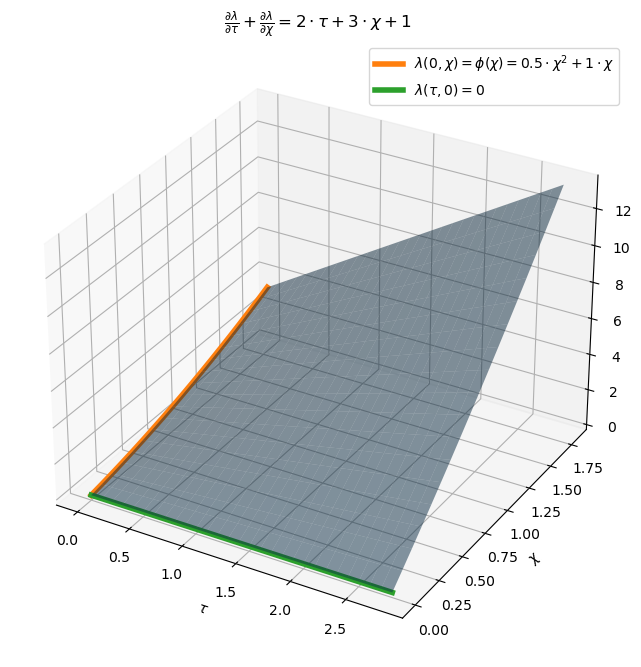

In [5]:
a, b, c, = 2, 3, 1

tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

solution = lambda_anal_n1_lintype(tau_space, chi_space, a=a, b=b, c=c)
initial = phi_lintype(chis, a=a, b=b, c=c)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fig.set_figheight(8)
fig.set_figwidth(10)

nu_str = f'{a}\\cdot\\tau + {b}\\cdot\\chi + {c}'
phi_str = f'{0.5*(b - a)}\\cdot\\chi^2 + {c}\\cdot\\chi'
title = r'$\frac{\partial\lambda}{\partial\tau} + \frac{\partial\lambda}{\partial\chi} = ' + nu_str + '$'

ax.set_title(title)
ax.plot_surface(tau_space, chi_space, solution, alpha=0.5)
ax.plot(0*chis, chis, initial, label=r'$\lambda(0, \chi) = \phi(\chi) = ' + phi_str + '$', linewidth=4)
ax.plot(taus, 0*taus, 0*taus, label=r'$\lambda(\tau, 0) = 0$', linewidth=4)

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\chi$')
ax.set_zlabel(r'$\lambda$')

ax.legend()

fig.show()

## Exponential $\nu$

Let $\nu(\tau, \chi)$ be like
$$
    \nu(\tau, \chi) = e^{a\tau + b\chi + \ln c} = c\cdot e^{a\tau + b\chi}
$$

Let's write characteristic equations:
$$
\cfrac{d\chi}{1} = \cfrac{d\tau}{1} = \cfrac{d\lambda}{c\cdot e^{a\tau + b\chi}}
$$

Solving the equation 
$$d\chi = d\tau$$
we will get: 
$$c_1 = \chi - \tau$$

Solving the equation 
$$ad\tau + bd\chi = (a + b)\cfrac{d\lambda}{e^{a\tau + b\chi}}$$
we will get: 
$$c_2 = e^{a\tau + b\chi} - \cfrac{a = b}{c}\lambda$$

1. $\lambda(\tau, 0) = 0$
$$
\begin{cases}
\chi = 0 \\
\lambda = 0 \\
c_1 = \chi - \tau \\
c_2 = c_2 = e^{a\tau + b\chi} - \cfrac{a = b}{c}\lambda \\
F_1(c_1, c_2) = 0
\end{cases}
$$

In this case $c_1 = -\tau$, $c_2 = e^{a\tau}$. So $F_1$ can be represented as
$$
F_1(c_1, c_2) = c_2 - e^{-a\cdot c_1}
$$
$$
F_1(\tau, \chi, \lambda) = e^{a\tau + b\chi} - e^{a\tau - a\chi} - \cfrac{a + b}{c}\lambda
$$

Cause $F_1(\tau, \chi, \lambda) = 0$ we can represent $\lambda$:
$$
\lambda = \cfrac{c}{a + b}(e^{a\tau + b\chi} - e^{a\tau - a\chi})
$$


And now we can define $\phi(\chi)$:
$$
\phi(\chi) =
\lambda(0, \chi) = \cfrac{c}{a + b}(e^{b\chi} - e^{- a\chi})
$$


In [6]:
def nu_exptype(tau, chi, a=1, b=1, c=1):
    return c*np.exp(a*tau + b*chi)

In [7]:
def lambda_anal_n1_exptype(tau, chi, a=1, b=1, c=1):
    return c/(a + b)*(np.exp(a*tau + b*chi) - np.exp(a*tau - a*chi))

In [8]:
def phi_exptype(chi, a=1, b=1, c=1):
    return c/(a + b)*(np.exp(b*chi) - np.exp(-a*chi))

/tmp/ipykernel_26536/3617411968.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


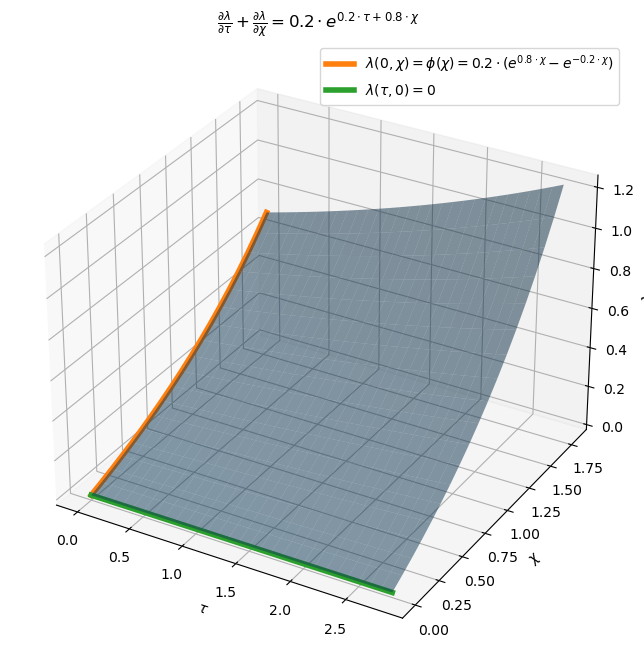

In [9]:
a, b, c, = 0.2, 0.8, 0.2

tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

solution = lambda_anal_n1_exptype(tau_space, chi_space, a=a, b=b, c=c)
initial = phi_exptype(chis, a=a, b=b, c=c)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fig.set_figheight(8)
fig.set_figwidth(8)

nu_str = f'{c}\\cdot e^' + '{' + str(a) + r'\cdot\tau' + ' + ' + str(b) + r'\cdot\chi' + '}'
phi_str = f'{c/(a+b)}\\cdot(e^' + '{' + f'{b}\\cdot\\chi' +  '} - e^{' + f'{-a}\\cdot\\chi' + '})'
title = r'$\frac{\partial\lambda}{\partial\tau} + \frac{\partial\lambda}{\partial\chi} = ' + nu_str + '$'

ax.set_title(title)
ax.plot_surface(tau_space, chi_space, solution, alpha=0.5)
ax.plot(0*chis, chis, initial, label=r'$\lambda(0, \chi) = \phi(\chi) = ' + phi_str + '$', linewidth=4)
ax.plot(taus, 0*taus, 0*taus, label=r'$\lambda(\tau, 0) = 0$', linewidth=4)


ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\chi$')
ax.set_zlabel(r'$\lambda$')

ax.legend()

fig.show()

# Analytical solutions. n = 2
We should find an analytical solution of the equation
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^2 = \nu(\tau, \chi)
$$

Where there are inintial and border constraints:
1. $\lambda(\tau, 0) = 0$
2. $\lambda(0, \chi) = \phi(\chi)$

## Direct sum of functions of 1 argument:  $\nu(\tau, \chi) = f(\tau) + g(\chi)$
If $\nu(\tau, \chi) = f(\tau) + g(\chi)$, the equation looks like
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^2 = f(\tau) + g(\chi)
$$

There is a [solution](https://eqworld.ipmnet.ru/en/solutions/fpde/fpde3103.pdf) for equations like this:
$$
\lambda(\tau, \chi) = -c_1\tau + \int\limits_0^\tau f(t)dt + \int\limits_0^\chi\sqrt{g(x) + c_1}dx + c_2
$$

1. $\lambda(\tau, 0) = 0$
$$
\lambda(\tau, 0) = -c_1\tau + \int\limits_0^\tau f(t)dt + c_2 = 0
$$
$$
\int\limits_0^\tau f(t)dt = c_1\tau - c_2
$$
Let's set $c_2 = 0$ and take the derivative
$$
f(\tau) = c_1
$$
2. $\lambda(0, \chi) = \phi(\chi)$
$$
\int\limits_0^\chi \sqrt{g(x) + c_1}dx + c_1 = \phi(\chi)
$$
take the derivative
$$
\sqrt{g(\chi) + c_1} = \phi\prime(\chi)
$$
$$
g(\chi) = (\phi\prime(\chi))^2 - c_1
$$
And finally:
$$
\nu(\tau. \chi) = f(\tau) + g(\chi) = (\phi\prime(\chi))^2
$$
does not depend on $\tau$.

P.s.: 

In [10]:
def lambda_anal_n2_direct_sum(tau, chi, 
                              nu=lambda tau, chi: chi**2, 
                              c1=0, c2=0):
    # nu(tau, chu) should be represented as sum f(tau) + g(chi)
    f = lambda t: nu(t, 0)
    g = lambda x: nu(0, x)
    root_gc1 = lambda x: (g(x) + c1)**0.5
    return -c1*tau + sp.integrate.quad(f, 0, tau)[0] + sp.integrate.quad(root_gc1, 0, chi)[0] + c2

/tmp/ipykernel_26536/3603537844.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


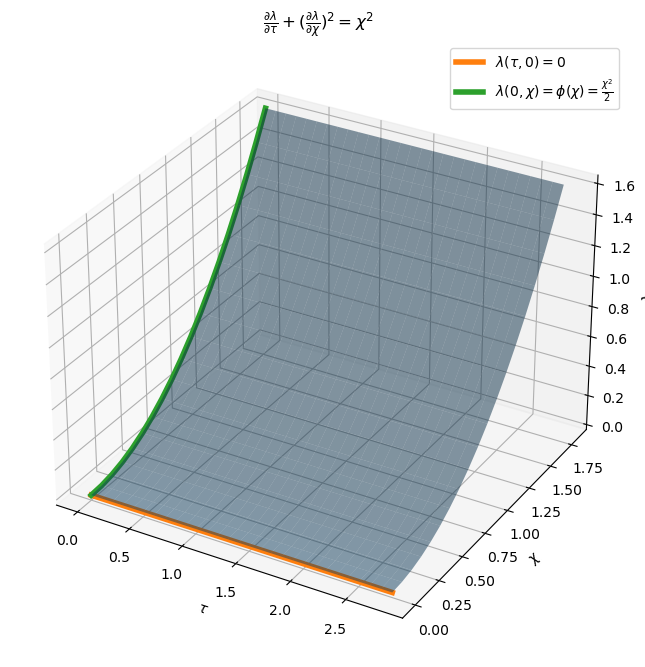

In [11]:
nu = lambda tau, chi: chi**2
nu_str = r'\chi^2'


tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

solution = np.array([[lambda_anal_n2_direct_sum(tau_space[j, k], chi_space[j, k], nu)
                      for k in range(nchi)] for j in range(ntau)])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fig.set_figheight(8)
fig.set_figwidth(8)

ax.set_title(r'$\frac{\partial\lambda}{\partial\tau} + (\frac{\partial\lambda}{\partial\chi})^2 = ' + nu_str + '$')
ax.plot_surface(tau_space, chi_space, solution, alpha=0.5)
ax.plot(taus, 0*taus, 0*taus, label=r'$\lambda(\tau, 0) = 0$', linewidth=4)
ax.plot(0*chis, chis, 0.5*chis**2, label=r'$\lambda(0, \chi) = \phi(\chi) = \frac{\chi^2}{2}$', linewidth=4)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\chi$')
ax.set_zlabel(r'$\lambda$')

ax.legend()

fig.show()

## Function to linear over $\chi$:  $\nu(\chi, \tau) = f(\tau)\cdot\chi + g(\tau)$

If $\nu(\tau, \chi) = f(\tau)\cdot\chi + g(\tau)$, the equation looks like
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^2 = f(\tau)\cdot\chi + g(\tau)
$$

There is a [solution](https://eqworld.ipmnet.ru/en/solutions/fpde/fpde3104.pdf) for equations like this:
$$
\lambda(\tau, \chi) = \psi(\tau)\cdot\chi + \int\limits_0^\tau [g(t) - \psi^2(t)]dt + c_1
$$
where
$$
\psi(\tau) = \int\limits_0^\tau f(t)dt + c_2
$$

1. $\lambda(\tau, 0) = 0$
$$
\int\limits_0^\tau [g(t) - \psi^2(t)] dt + c_1 = 0
$$
Let's take the derivative
$$
g(\tau) = \psi^2(\tau)
$$
so
$$
g(\tau) = [\int\limits_0^\tau f(t)dt + c_2]^2
$$

2. $\lambda(0, \chi) = \phi(\chi)$
$$
\phi(\chi) = \lambda(0, \chi) = \psi(0)\cdot\chi + c_1
$$
we can easily understand that $\psi(0) = c_2$ so
$$
\phi(\chi) = c_2\chi + c_1
$$
$\phi$ should be linear.

And we can define $c_1$ from the 1st constrain: $\lambda(0, 0) = c_1 = 0$

### Examples
1. The example of function like this we can get by seting $f(\tau) = e^\tau$ and $c_2 = 1$, then
$$
g(\tau) = [\int\limits_0^\tau e^t dt + 1]^2 = [e^t - 1 + 1]^2 = e^{2t}
$$
and so 
$$
\nu(\tau, \chi) = f(\tau)\chi + g(\tau) = e^{\tau}\chi + e^{2\tau}
$$
2. Let's set $f(\tau) = e^{-\tau}$ and $c_2 = 1$, then
$$
g(\tau) = [\int\limits_0^\tau e^{-t}dt + 1]^2 = [2 - e^{-\tau}]^2
$$
and so 
$$
\nu(\tau, \chi) = f(\tau)\chi + g(\tau) = e^{-\tau}\chi + [2 - e^{-\tau}]^2
$$

In [12]:
def lambda_anal_n2_linear(tau, chi, 
                          nu=lambda tau, chi: np.exp(tau)*chi + np.exp(2*tau), 
                          c1=0, c2=1):
    # nu(tau, chu) should be represented as sum f(tau)*chi + g(chi)
    f = lambda t: nu(t, 1) - nu(t, 0)
    g = lambda t: nu(t, 0)
    
    psi = lambda t: sp.integrate.quad(f, 0, t)[0] + c2
    
    under = lambda t: g(t) - psi(t)**2
    return psi(tau)*chi + sp.integrate.quad(under, 0, tau)[0] + c1

/tmp/ipykernel_26536/120056514.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


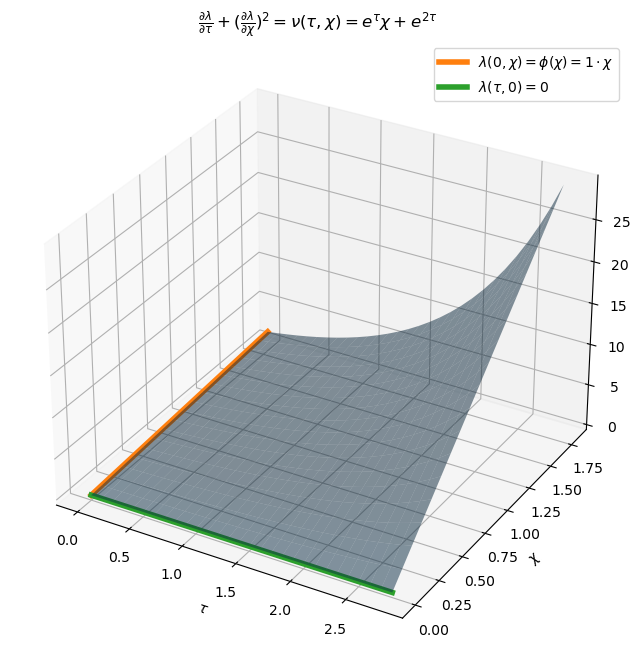

In [13]:
c1, c2 = 0, 1
nu = lambda tau, chi: np.exp(tau)*chi + np.exp(2*tau)
nu_str = r'\nu(\tau, \chi) = e^\tau\chi + e^{2\tau}'

tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

solution = np.array([[lambda_anal_n2_linear(tau_space[j, k], chi_space[j, k], nu, c1=c1, c2=c2)
                      for k in range(nchi)] for j in range(ntau)])
initial = c2*chis
phi_str = f'{c2}\\cdot\\chi'

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fig.set_figheight(8)
fig.set_figwidth(8)

ax.set_title(r'$\frac{\partial\lambda}{\partial\tau} + (\frac{\partial\lambda}{\partial\chi})^2 = ' + nu_str + '$')
ax.plot_surface(tau_space, chi_space, solution, alpha=0.5)
ax.plot(0*chis, chis, initial, label=r'$\lambda(0, \chi) = \phi(\chi) = ' + phi_str + '$', linewidth=4)
ax.plot(taus, 0*taus, 0*taus, label=r'$\lambda(\tau, 0) = 0$', linewidth=4)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\chi$')
ax.set_zlabel(r'$\lambda$')

ax.legend()

fig.show()

/tmp/ipykernel_26536/3391915499.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


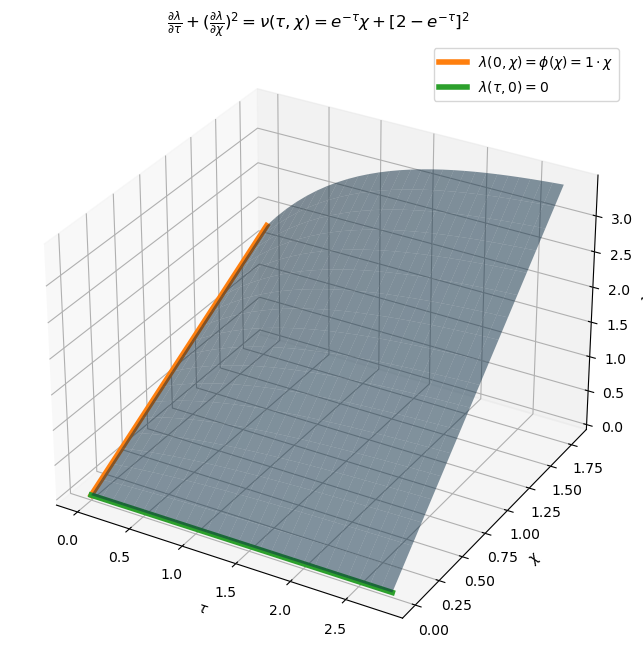

In [14]:
c1, c2 = 0, 1
nu = lambda tau, chi: np.exp(-tau)*chi + (2 - np.exp(-tau))**2
nu_str = r'\nu(\tau, \chi) = e^{-\tau}\chi + [2 - e^{-\tau}]^2'

tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

solution = np.array([[lambda_anal_n2_linear(tau_space[j, k], chi_space[j, k], nu, c1=c1, c2=c2)
                      for k in range(nchi)] for j in range(ntau)])
initial = c2*chis
phi_str = f'{c2}\\cdot\\chi'

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fig.set_figheight(8)
fig.set_figwidth(8)

ax.set_title(r'$\frac{\partial\lambda}{\partial\tau} + (\frac{\partial\lambda}{\partial\chi})^2 = ' + nu_str + '$')
ax.plot_surface(tau_space, chi_space, solution, alpha=0.5)
ax.plot(0*chis, chis, initial, label=r'$\lambda(0, \chi) = \phi(\chi) = ' + phi_str + '$', linewidth=4)
ax.plot(taus, 0*taus, 0*taus, label=r'$\lambda(\tau, 0) = 0$', linewidth=4)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\chi$')
ax.set_zlabel(r'$\lambda$')

ax.legend()

fig.show()

# Analytical solutions. n = 0.5
We should find an analytical solution of the equation
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^{1/2} = \nu(\tau, \chi)
$$

Where there are inintial and border constraints:
1. $\lambda(\tau, 0) = 0$
2. $\lambda(0, \chi) = \phi(\chi)$

## Function to linear over $\chi$:  $\nu(\chi, \tau) = g(\tau)\cdot\chi + h(\tau)$

If $\nu(\tau, \chi) = f(\tau)\cdot\chi + g(\tau)$, the equation looks like
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^{1/2} = g(\tau)\cdot\chi + h(\tau)
$$

There is a [solution](https://eqworld.ipmnet.ru/en/solutions/fpde/fpde3303.pdf) for equations like this:
$$
\lambda(\tau, \chi) = \psi(\tau)\chi + \int\limits_0^\tau [h(t) - \psi^{1/2}(t)]dt + c_1
$$
where
$$
\psi(\tau) = \int\limits_0^\tau g(t)dt + c_2
$$

1. $\lambda(\tau, 0) = 0$
$$
\lambda(\tau, 0) = 
\int\limits_0^\tau [h(t) - \psi^{1/2}(t)] dt + c_1 = 0
$$
Let's take the derivative
$$
h(\tau) = \psi^{1/2}(t)
$$
so
$$
h(\tau) = (\int\limits_0^\tau g(t)dt + c_2)^{1/2}
$$


2. $\lambda(0, \chi) = \phi(\chi)$
$$
\phi(\chi) = \lambda(0, \chi) = \psi(0)\cdot\chi + c_1
$$
we can easily understand that $\psi(0) = c_2$ so
$$
\phi(\chi) = c_2\chi + c_1
$$
$\phi$ should be linear.

And we can define $c_1$ from the 1st constrain: $\lambda(0, 0) = c_1 = 0$

__Note:__ Here we described the situation, when $n=0.5$. But that's easy to change $n$ to any real value.

### Examples

1. The example of function like this we can get by seting $f(\tau) = e^\tau$ and $c_2 = 1$, then
$$
g(\tau) = [\int\limits_0^\tau e^t dt + 1]^{1/2} = [e^t - 1 + 1]^{1/2} = e^{t/2}
$$
and so 
$$
\nu(\tau, \chi) = f(\tau)\chi + g(\tau) = e^{\tau}\chi + e^{\tau/2}
$$

2. Let's set $f(\tau) = e^{-\tau}$ and $c_2 = 1$, then
$$
g(\tau) = [\int\limits_0^\tau e^{-t}dt + 1]^2 = [2 - e^{-\tau}]^{1/2}
$$
and so 
$$
\nu(\tau, \chi) = f(\tau)\chi + g(\tau) = e^{-\tau}\chi + [2 - e^{-\tau}]^{1/2}
$$

In [15]:
def lambda_anal_ng_linear(tau, chi, 
                          nu=lambda tau, chi: np.exp(tau)*chi + np.exp(2*tau), 
                          c1=0, c2=1, n=0.5):
    # nu(tau, chu) should be represented as sum g(tau)*chi + h(chi)
    f = lambda t: t**n
    g = lambda t: nu(t, 1) - nu(t, 0)
    h = lambda t: nu(t, 0)
    
    psi = lambda t: sp.integrate.quad(g, 0, t)[0] + c2
    under = lambda t: h(t) - f(psi(t))
    
    result = psi(tau)*chi + sp.integrate.quad(under, 0, tau)[0] + c1
    return result

/tmp/ipykernel_26536/88092152.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


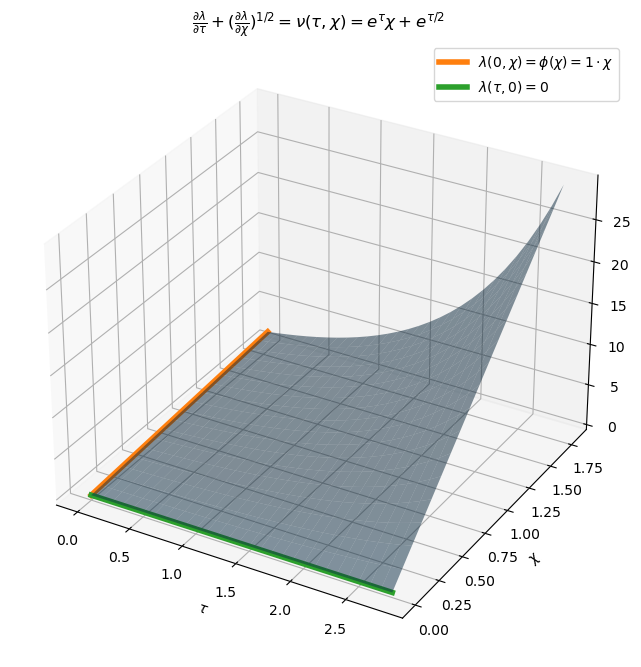

In [16]:
c1, c2 = 0, 1
nu = lambda tau, chi: np.exp(tau)*chi + np.exp(0.5*tau)
nu_str = r'\nu(\tau, \chi) = e^\tau\chi + e^{\tau/2}'

tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

solution = np.array([[lambda_anal_ng_linear(tau_space[j, k], chi_space[j, k], nu, c1=c1, c2=c2, n=0.5)
                      for k in range(nchi)] for j in range(ntau)])
initial = c2*chis
phi_str = f'{c2}\\cdot\\chi'

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fig.set_figheight(8)
fig.set_figwidth(8)

ax.set_title(r'$\frac{\partial\lambda}{\partial\tau} + (\frac{\partial\lambda}{\partial\chi})^{1/2} = ' + nu_str + '$')
ax.plot_surface(tau_space, chi_space, solution, alpha=0.5)
ax.plot(0*chis, chis, initial, label=r'$\lambda(0, \chi) = \phi(\chi) = ' + phi_str + '$', linewidth=4)
ax.plot(taus, 0*taus, 0*taus, label=r'$\lambda(\tau, 0) = 0$', linewidth=4)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\chi$')
ax.set_zlabel(r'$\lambda$')

ax.legend()

fig.show()

/tmp/ipykernel_26536/3467663766.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


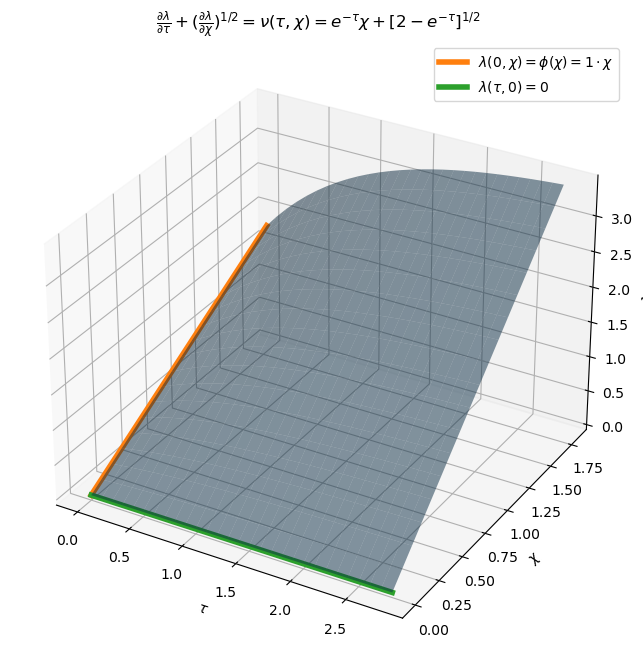

In [17]:
c1, c2 = 0, 1
nu = lambda tau, chi: np.exp(-tau)*chi + (2 - np.exp(-tau))**0.5
nu_str = r'\nu(\tau, \chi) = e^{-\tau}\chi + [2 - e^{-\tau}]^{1/2}'

tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

solution = np.array([[lambda_anal_ng_linear(tau_space[j, k], chi_space[j, k], nu, c1=c1, c2=c2, n=0.5)
                      for k in range(nchi)] for j in range(ntau)])
initial = c2*chis
phi_str = f'{c2}\\cdot\\chi'

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fig.set_figheight(8)
fig.set_figwidth(8)

ax.set_title(r'$\frac{\partial\lambda}{\partial\tau} + (\frac{\partial\lambda}{\partial\chi})^{1/2} = ' + nu_str + '$')
ax.plot_surface(tau_space, chi_space, solution, alpha=0.5)
ax.plot(0*chis, chis, initial, label=r'$\lambda(0, \chi) = \phi(\chi) = ' + phi_str + '$', linewidth=4)
ax.plot(taus, 0*taus, 0*taus, label=r'$\lambda(\tau, 0) = 0$', linewidth=4)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\chi$')
ax.set_zlabel(r'$\lambda$')

ax.legend()

fig.show()

# Analytical solutions. General n
We should find an analytical solution of the equation
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^{n} = \nu(\tau, \chi)
$$

Where there are inintial and border constraints:
1. $\lambda(\tau, 0) = 0$
2. $\lambda(0, \chi) = \phi(\chi)$

## Function to linear over $\chi$:  $\nu(\chi, \tau) = g(\tau)\cdot\chi + h(\tau)$
__Note:__ This is a generalisation of cases, described before.

If $\nu(\tau, \chi) = f(\tau)\cdot\chi + g(\tau)$, the equation looks like
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^{n} = g(\tau)\cdot\chi + h(\tau)
$$

There is a [solution](https://eqworld.ipmnet.ru/en/solutions/fpde/fpde3303.pdf) for equations like this:
$$
\lambda(\tau, \chi) = \psi(\tau)\chi + \int\limits_0^\tau [h(t) - \psi^{n}(t)]dt + c_1
$$
where
$$
\psi(\tau) = \int\limits_0^\tau g(t)dt + c_2
$$


1. $\lambda(\tau, 0) = 0$
$$
\lambda(\tau, 0) = 
\int\limits_0^\tau [h(t) - \psi^{n}(t)] dt + c_1 = 0
$$
Let's take the derivative
$$
h(\tau) = \psi^{1/2}(t)
$$
so
$$
h(\tau) = (\int\limits_0^\tau g(t)dt + c_2)^{n}
$$


2. $\lambda(0, \chi) = \phi(\chi)$
$$
\phi(\chi) = \lambda(0, \chi) = \psi(0)\cdot\chi + c_1
$$
we can easily understand that $\psi(0) = c_2$ so
$$
\phi(\chi) = c_2\chi + c_1
$$
$\phi$ should be linear.

And we can define $c_1$ from the 1st constrain: $\lambda(0, 0) = c_1 = 0$


### Examples

1. The example of function like this we can get by seting $f(\tau) = e^\tau$ and $c_2 = 1$, then
$$
g(\tau) = [\int\limits_0^\tau e^t dt + 1]^{1/2} = [e^t - 1 + 1]^{n} = e^{n}
$$
and so 
$$
\nu(\tau, \chi) = f(\tau)\chi + g(\tau) = e^{\tau}\chi + e^{n\tau}
$$
$$
\lambda(\tau, \chi) = e^\tau\chi
$$

2. Let's set $f(\tau) = e^{-\tau}$ and $c_2 = 1$, then
$$
g(\tau) = [\int\limits_0^\tau e^{-t}dt + 1]^2 = [2 - e^{-\tau}]^{n}
$$
and so 
$$
\nu(\tau, \chi) = f(\tau)\chi + g(\tau) = e^{-\tau}\chi + [2 - e^{-\tau}]^{n}
$$
$$
\lambda(\tau, \chi) = (2 - e^{-\tau})^n
$$

3. Let's $f(\tau) = \frac{1}{\tau + 1}$ and $c_2 = 1$, then
$$
\psi(\tau) = \int\limits_0^\tau \frac{1}{t+1}dt + 1 = \ln(\tau + 1) + 1
$$
$$
g(\tau) = \psi^n(\tau) = (\ln(\tau + 1) + 1)^n
$$
and so 
$$
\nu(\tau, \chi) = (\ln(\tau + 1) + 1)^n\chi + \frac{1}{\tau + 1}
$$
$$
\lambda(\tau, \chi) = (\ln(\tau + 1) + 1)\chi
$$

__P.S.:__ I have not used the 3rd example yet.

In [18]:
pass

# Problems list

Here we will define problems as list of dicts. Each problem should contain following fields:
- `'analytical'` - the analytical solution $\lambda(\tau, \chi)$ of the problem; real function of two arguments
- `'title'` - the problem equation; string in LaTeX format
- `'nu'` - the function $\nu(\tau, \chi)$ from right side; real function of two arguments
- `'border'` - the border function $\lambda(\tau, 0)$; real function of one argument
- `'border-str'` - the border function description;  string in LaTeX format
- `'initial'` - the initial function $\lambda(0, \chi)$; real function of one argument
- `'initial-str'` - the initial function description;  string in LaTeX format
- `'n'` - the exponent of derivative over $\chi$ - real number

In [19]:
problems = []

# n = 1; linear type
for a, b, c in [(2, 3, 1)]:
    problems.append({
        'analytical': lambda tau, chi: lambda_anal_n1_lintype(tau, chi, a=a, b=b, c=c), 
        'title': r'$\frac{\partial\lambda}{\partial\tau} + \frac{\partial\lambda}{\partial\chi} = ' + f'{a}\\cdot\\tau + {b}\\cdot\\chi + {c}' + '$', 
        'nu': lambda tau, chi: a*tau + b*chi + c, 
        'border': lambda tau: tau*0, 
        'border-str': '$\\lambda(\\tau, 0) = 0$', 
        'initial': lambda chi: 0.5*(b-a)*chi**2 + c*chi,
        'initial-str': f'$\\lambda(0, \\chi) = {0.5*(b-a)}\\cdot\\chi^2 + {c}\\cdot\\chi$', 
        'n' : 1
    })
    
# n = 1; exponential type
for a, b, c in [(0.8, 0.2, 0.25), 
                (0.2, 0.8, 0.25)]:
    b_sign = {True: '+', False: '-'}[b >= 0]
    problems.append({
        'analytical': lambda tau, chi: lambda_anal_n1_exptype(tau, chi, a=a, b=b, c=c), 
        'title': r'$\frac{\partial\lambda}{\partial\tau} + \frac{\partial\lambda}{\partial\chi} = ' + f'{c}\\cdot e^' + '{' + f'{a}\\cdot\\tau {b_sign} {abs(b)}\\cdot\\chi'+ '}$', 
        'nu' : lambda tau, chi: c*np.exp(a*tau + b*chi), 
        'border': lambda tau: tau*0, 
        'border-str': '$\\lambda(\\tau, 0) = 0$', 
        'initial' : lambda chi: c/(a + b)*(np.exp(b*chi) - np.exp(-a*chi)), 
        'initial-str': f'${c/(a + b)}\\cdot(e^' + '{' + str(b) + r'\cdot\chi} - e^{' + str(-a) + r'\cdot\chi})$', 
        'n' : 1
    })
    
# n = 2
problems.append({
    # double integration is too long, so I replace this with analyticall found function
    #'analytical': lambda tau, chi: lambda_anal_n2_direct_sum(tau, chi, 
    #                                                         nu=lambda tau, chi: chi**2, 
    #                                                         c1=0, c2=0), 
    'analytical': lambda tau, chi: 0.5*chi**2, 
    'analytical-str': r'$\lambda(\tau, \chi)$ = \chi^2$', 
    'title': r'$\frac{\partial\lambda}{\partial\tau} + (\frac{\partial\lambda}{\partial\chi})^2 = \chi^2$', 
    'nu': lambda tau, chi: chi**2, 
    'border': lambda tau: tau*0, 
    'border-str': '$\\lambda(\\tau, 0) = 0$', 
    'initial': lambda chi: 0.5*chi**2, 
    'initial-str': r'$\lambda(0, \chi) = \frac{\chi^2}{2}$',
    'n' : 2
})

problems.append({
    # double integration is too long, so I replace this with analyticall found function
    #'analytical': lambda tau, chi: lambda_anal_n2_linear(tau, chi,
    #                                                     nu=lambda tau, chi: np.exp(tau)*chi + np.exp(2*tau), 
    #                                                     c1=0, c2=1),
    'analytical': lambda tau, chi: np.exp(tau)*chi, 
    'analytical-str': r'$\lambda(\tau, \chi)$ = e^\tau\chi$', 
    'title': r'$\frac{\partial\lambda}{\partial\tau} + (\frac{\partial\lambda}{\partial\chi})^2 = e^\tau\chi + e^{2\tau}$', 
    'nu' : lambda tau, chi: np.exp(tau)*chi + np.exp(2*tau), 
    'border': lambda tau: tau*0, 
    'border-str': '$\\lambda(\\tau, 0) = 0$', 
    'initial': lambda chi: chi, 
    'initial-str': r'$\lambda(0, \chi) = \chi$',
    'n' : 2
})


problems.append({
    # double integration is too long, so I replace this with analyticall found function
    #'analytical': lambda tau, chi: lambda_anal_n2_linear(tau, chi,
    #                                                     nu=lambda tau, chi: np.exp(-tau)*chi + (2 - np.exp(-tau))**2, 
    #                                                     c1=0, c2=1),
    'analytical': lambda tau, chi: (2 - np.exp(-tau))*chi, 
    'analytical-str': r'$\lambda(\tau, \chi)$ = (2 - e^{-\tau})\chi$', 
    'title': r'$\frac{\partial\lambda}{\partial\tau} + (\frac{\partial\lambda}{\partial\chi})^2 = e^{-\tau}\chi + [2 - e^{-\tau}]^2$', 
    'nu' : lambda tau, chi: np.exp(-tau)*chi + (2 - np.exp(-tau))**2,
    'border': lambda tau: tau*0, 
    'border-str': '$\\lambda(\\tau, 0) = 0$', 
    'initial': lambda chi: chi, 
    'initial-str': r'$\lambda(0, \chi) = \chi$',
    'n' : 2
})

# n = 0.5
problems.append({
    # double integration is too long, so I replace this with analyticall found function
    #'analytical': lambda tau, chi: lambda_anal_ng_linear(tau, chi, 
    #                                                     lambda tau, chi: np.exp(tau)*chi + np.exp(0.5*tau), 
    #                                                     c1=0, c2=1, n=0.5), 
    'analytical': lambda tau, chi: np.exp(tau)*chi, 
    'analytical-str': r'$\lambda(\tau, \chi)$ = e^\tau\chi$', 
    'title': r'$\frac{\partial\lambda}{\partial\tau} + (\frac{\partial\lambda}{\partial\chi})^{1/2} = e^\tau\chi + e^{\tau/2}$', 
    'nu': lambda tau, chi: np.exp(tau)*chi + np.exp(0.5*tau), 
    'border': lambda tau: tau*0, 
    'border-str': '$\\lambda(\\tau, 0) = 0$', 
    'initial': lambda chi: chi, 
    'initial-str': r'$\lambda(0, \chi) = \chi$',
    'n' : 0.5
})

problems.append({
    # double integration is too long, so I replace this with analyticall found function
    #'analytical': lambda tau, chi: lambda_anal_ng_linear(tau, chi, 
    #                                                     lambda tau, chi: np.exp(-tau)*chi + (2 - np.exp(-tau))**0.5, 
    #                                                     c1=0, c2=1, n=0.5), 
    'analytical': lambda tau, chi: (2 - np.exp(-tau))*chi, 
    'analytical-str': r'$\lambda(\tau, \chi)$ = (2 - e^{-\tau})\chi$', 
    'title': r'$\frac{\partial\lambda}{\partial\tau} + (\frac{\partial\lambda}{\partial\chi})^{1/2} = e^{-\tau}\chi + (2 - e^{-\tau})^{1/2}$', 
    'nu': lambda tau, chi: np.exp(-tau)*chi + (2 - np.exp(-tau))**0.5, 
    'border': lambda tau: tau*0, 
    'border-str': '$\\lambda(\\tau, 0) = 0$', 
    'initial': lambda chi: chi, 
    'initial-str': r'$\lambda(0, \chi) = \chi$',
    'n' : 0.5
})

for n in [0.33, 0.67, 1.5]:
    # direct exponent linear nu
    problems.append(
        {
            'analytical': lambda tau, chi: np.exp(tau)*chi, 
            'analytical-str': r'$\lambda(\tau, \chi)$ = e^\tau\chi$', 
            'title': r'$\frac{\partial\lambda}{\partial\tau} + (\frac{\partial\lambda}{\partial\chi})^{' + str(n) + r'} = e^\tau\chi + e^{' + str(n) + r'\cdot\tau}$', 
            'nu': lambda tau, chi: np.exp(tau)*chi + np.exp(n*tau), 
            'border': lambda tau: tau*0, 
            'border-str': '$\\lambda(\\tau, 0) = 0$', 
            'initial': lambda chi: chi, 
            'initial-str': r'$\lambda(0, \chi) = \chi$',
            'n' : n
        }
    )
    
    # inverse exponent linear nu
    problems.append({
        'analytical': lambda tau, chi: (2 - np.exp(-tau))*chi, 
        'analytical-str': r'$\lambda(\tau, \chi)$ = (2 - e^{-\tau})\chi$', 
        'title': r'$\frac{\partial\lambda}{\partial\tau} + (\frac{\partial\lambda}{\partial\chi})^{' + str(n) + r'} = e^{-\tau}\chi + (2 - e^{-\tau})^{' + str(n) + '}$', 
        'nu': lambda tau, chi: np.exp(-tau)*chi + (2 - np.exp(-tau))**n, 
        'border': lambda tau: tau*0, 
        'border-str': '$\\lambda(\\tau, 0) = 0$', 
        'initial': lambda chi: chi, 
        'initial-str': r'$\lambda(0, \chi) = \chi$',
        'n' : n
    })

In [20]:
tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

solutions = []

for problem in tqdm(problems, total=len(problems)):
    try:
        solution = problem['analytical'](tau_space, chi_space)
    except ValueError:
        solution = [[problem['analytical'](tau_space[j, k], chi_space[j, k]) 
                     for k in range(tau_space.shape[1])] 
                    for j in range(tau_space.shape[0])]
    solutions.append(np.array(solution))
    
np.array(solutions).shape

  0%|          | 0/14 [00:00<?, ?it/s]

(14, 29, 19)

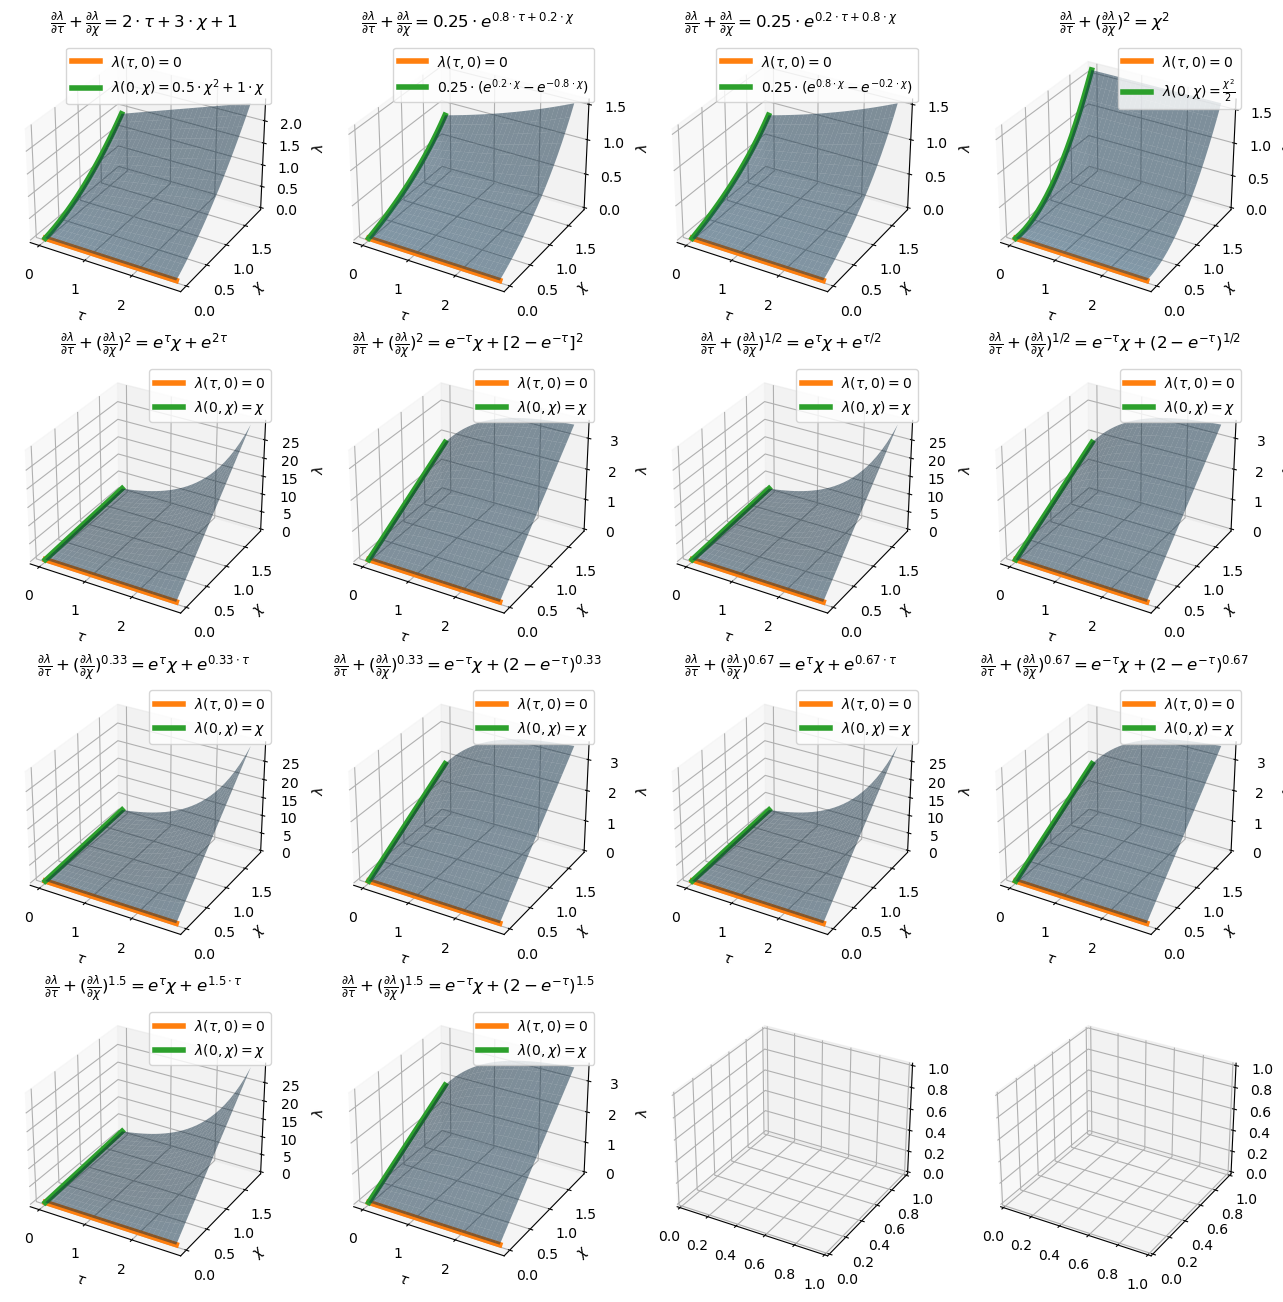

In [21]:
nrows = np.ceil(len(problems)**0.5).astype(int)
ncols = np.ceil(len(problems) / nrows).astype(int)

fig, axs = plt.subplots(nrows, ncols, subplot_kw={"projection": "3d"})
fig.set_figheight(16)
fig.set_figwidth(16)


for i, problem in enumerate(problems):
    irow = i//ncols
    icol = i%ncols
    axs[irow, icol].set_title(problem['title'])
    
    solution = solutions[i]
    axs[irow, icol].plot_surface(tau_space, chi_space, solution, alpha=0.5)
    try:
        axs[irow, icol].plot(taus, 0*taus, problem['border'](taus), label=problem['border-str'], linewidth=4)
    except KeyError:
        pass
    try:
        axs[irow, icol].plot(0*chis, chis, problem['initial'](chis), label=problem['initial-str'], linewidth=4)
    except KeyError:
        pass
    
    axs[irow, icol].set_xlabel(r'$\tau$')
    axs[irow, icol].set_ylabel(r'$\chi$')
    axs[irow, icol].set_zlabel(r'$\lambda$')

    axs[irow, icol].legend()

# Schemes

In [22]:
from src import approximation

We will define schemes to check as list of dicts. Each dict should contain:
- `'scheme'` - approximation function
- `'bar-total'` - the number of iterations for tqdm bar or None, if function can not use bar

In [23]:
approximators = [
    {
        'scheme' : approximation.approximate_by1scheme,
        'bar-total': lambda ntau, nchi: (ntau - 1)*(nchi - 1) 
    }, 
    {
        'scheme' : approximation.approximate_by2scheme,
        'bar-total': lambda ntau, nchi: (ntau - 1)*(nchi - 1) 
    }
]

# Comparing approximation schemes due problems

In [24]:
from sklearn.metrics import max_error,mean_absolute_error, explained_variance_score

In [25]:
scores = [max_error,mean_absolute_error, explained_variance_score]

## Smaller grid

In [26]:
# define parameters

dtau = 0.01
dchi = 0.01

ntau = 121
nchi = 121


taus = dtau*np.arange(ntau)
chis = dchi*np.arange(nchi)

tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

print(f'The grid on space τ×χ is defined by {ntau}×{nchi} points with step sizes dτ={dtau} and dχ={dchi}.')

The grid on space τ×χ is defined by 121×121 points with step sizes dτ=0.01 and dχ=0.01.


In [27]:
# find analytical solutions to the problems over grid

solutions_smoller = []

for problem in tqdm(problems, total=len(problems)):
    try:
        solution = problem['analytical'](tau_space, chi_space)
    except ValueError:
        solution = [[problem['analytical'](tau_space[j, k], chi_space[j, k]) 
                     for k in range(tau_space.shape[1])] 
                    for j in range(tau_space.shape[0])]
    solutions_smoller.append(np.array(solution))
    
np.array(solutions_smoller).shape

  0%|          | 0/14 [00:00<?, ?it/s]

(14, 121, 121)

In [28]:
# find approximations by schemes

approximations_smaller = []

with tqdm(total=len(problems)) as bar_problems:
    with tqdm(total=len(approximators)) as bar_schemes:
        with tqdm(total=ntau*nchi) as bar_inner:
            for i_problem in range(len(problems)):
                bar_schemes.reset()
                
                nu = problems[i_problem]['nu']
                n = problems[i_problem]['n']
                border = problems[i_problem]['border']
                initial = problems[i_problem]['initial']
                
                for i_scheme in range(len(approximators)):
                    bar_inner.reset()
                    scheme = approximators[i_scheme]['scheme']
                    
                    timer = time.perf_counter()
                    if approximators[i_scheme]['bar-total'] is None:
                        bar_inner.total = 1
                        bar_inner.refresh()
                        sol, tau, chi = scheme(nu=nu, initial=initial, border=border, n=n, 
                                               dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi)
                        bar_inner.update()
                    else:
                        bar_inner.total = approximators[i_scheme]['bar-total'](ntau, nchi)
                        bar_inner.refresh()
                        sol, tau, chi = scheme(nu=nu, initial=initial, border=border, n=n, 
                                               dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, 
                                               bar=bar_inner)
                    timer = time.perf_counter() - timer
                    approximations_smaller.append(
                        {
                            'problem-id': i_problem, 
                            'scheme-id': i_scheme, 
                            'scheme': approximators[i_scheme]['scheme'].__name__, 
                            'sol': np.array(sol), 
                            'tau': np.array(tau), 
                            'chi': np.array(chi), 
                            'time' : timer
                        }
                    )
                    
                    bar_schemes.update()
                bar_problems.update()
                
approximations_smaller = pd.DataFrame(approximations_smaller)

approximations_smaller.pivot(index='scheme', columns='problem-id', values='time')

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/14641 [00:00<?, ?it/s]

/usr/lib64/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/fedora/Jupyter/river-profiles/src/approximation.py:74: RuntimeWarning: invalid value encountered in power
  f = lambda sol: sol - sols[j, k+1] + dtau*((sol - sols[j+1, k])/dchi)**n - dtau*nu_val
/home/fedora/Jupyter/river-profiles/src/approximation.py:75: RuntimeWarning: invalid value encountered in sqrt
  fprime = lambda sol: 1 - n*(dtau/dchi)*((sol - sols[j+1, k])/dchi)**(n - 1)
/home/fedora/Jupyter/river-profiles/src/approximation.py:157: RuntimeWarning: invalid value encountered in power
  f = lambda sol: 0.5*(sol + sols[j+1, k] - sols[j, k+1] - sols[j, k])/dtau + (0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**n - nu_val
/home/fedora/Jupyter/river-profiles/src/approximation.py:158: RuntimeWarning: invalid value encountered in sqrt
  fp

problem-id                   0         1         2         3         4   \
scheme                                                                    
approximate_by1scheme  2.147032  2.149116  2.134367  1.548417  1.693565   
approximate_by2scheme  3.467865  3.522266  3.511967  2.444026  2.912710   

problem-id                   5         6         7         8         9   \
scheme                                                                    
approximate_by1scheme  1.718862  1.756355  1.723059  2.245600  2.237455   
approximate_by2scheme  2.599370  2.940047  2.819598  3.545072  3.480110   

problem-id                   10        11        12        13  
scheme                                                         
approximate_by1scheme  1.808576  1.819976  2.276642  2.404544  
approximate_by2scheme  2.957283  2.940781  2.763123  2.726156

In [29]:
approximations_smaller['lam'] = [problems[row['problem-id']]['analytical'](row['tau'], row['chi']) for index, row in approximations_smaller.iterrows()]
approximations_smaller = approximations_smaller.join(pd.DataFrame(problems), on='problem-id')


In [30]:
approximations_smaller['nu-str'] = ['$' + s[s.find('=') + 2:] for s in approximations_smaller['title']]

In [31]:
for score in scores:
    approximations_smaller[score.__name__] = [score(np.concatenate(approximations_smaller.loc[i, 'lam']), 
                                                    np.concatenate(approximations_smaller.loc[i, 'sol'])) for i in approximations_smaller.index]

In [32]:
approximations_smaller[np.concatenate([['n', 'nu-str', 'initial-str', 'scheme'], 
                                       [score.__name__ for score in scores]])].pivot(index=['n', 'nu-str', 'initial-str'], 
                                                                                     columns=['scheme'])

max_error  \
scheme                                                                                             approximate_by1scheme   
n    nu-str                                      initial-str                                                               
0.33 $e^\tau\chi + e^{0.33\cdot\tau}$            $\lambda(0, \chi) = \chi$                                      0.012866   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{0.33}$    $\lambda(0, \chi) = \chi$                                      0.003552   
0.50 $e^\tau\chi + e^{\tau/2}$                   $\lambda(0, \chi) = \chi$                                      0.012071   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{1/2}$     $\lambda(0, \chi) = \chi$                                      0.003158   
0.67 $e^\tau\chi + e^{0.67\cdot\tau}$            $\lambda(0, \chi) = \chi$                                      0.011061   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{0.67}$    $\lambda(0, \chi) = \chi$                                      0.002715   
1.00 $0.25\cdot e^{0.2\cdot\tau + 0.8\cdot\chi}$ $0.25\cdot(e^{0.8\cdot\chi} - e^{-0.2\cdot\chi})$              0.001804   
     $0.25\cdot e^{0.8\cdot\tau + 0.2\cdot\chi}$ $0.25\cdot(e^{0.2\cdot\chi} - e^{-0.8\cdot\chi})$              0.001804   
     $2\cdot\tau + 3\cdot\chi + 1$               $\lambda(0, \chi) = 0.5\cdot\chi^2 + 1\cdot\chi$               0.003415   
1.50 $e^\tau\chi + e^{1.5\cdot\tau}$             $\lambda(0, \chi) = \chi$                                      3.974040   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{1.5}$     $\lambda(0, \chi) = \chi$                                      2.028468   
2.00 $\chi^2$                                    $\lambda(0, \chi) = \frac{\chi^2}{2}$                          0.005437   
     $e^\tau\chi + e^{2\tau}$                    $\lambda(0, \chi) = \chi$                                      2.269135   
     $e^{-\tau}\chi + [2 - e^{-\tau}]^2$         $\lambda(0, \chi) = \chi$                                      0.545327   

                                                                                                                          \
scheme                                                                                             approximate_by2scheme   
n    nu-str                                      initial-str                                                               
0.33 $e^\tau\chi + e^{0.33\cdot\tau}$            $\lambda(0, \chi) = \chi$                                  1.678520e-05   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{0.33}$    $\lambda(0, \chi) = \chi$                                  1.977683e-06   
0.50 $e^\tau\chi + e^{\tau/2}$                   $\lambda(0, \chi) = \chi$                                  2.033453e-05   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{1/2}$     $\lambda(0, \chi) = \chi$                                  3.154493e-06   
0.67 $e^\tau\chi + e^{0.67\cdot\tau}$            $\lambda(0, \chi) = \chi$                                  2.465750e-05   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{0.67}$    $\lambda(0, \chi) = \chi$                                  4.444468e-06   
1.00 $0.25\cdot e^{0.2\cdot\tau + 0.8\cdot\chi}$ $0.25\cdot(e^{0.8\cdot\chi} - e^{-0.2\cdot\chi})$          2.416781e-06   
     $0.25\cdot e^{0.8\cdot\tau + 0.2\cdot\chi}$ $0.25\cdot(e^{0.2\cdot\chi} - e^{-0.8\cdot\chi})$          2.416781e-06   
     $2\cdot\tau + 3\cdot\chi + 1$               $\lambda(0, \chi) = 0.5\cdot\chi^2 + 1\cdot\chi$           9.992007e-16   
1.50 $e^\tau\chi + e^{1.5\cdot\tau}$             $\lambda(0, \chi) = \chi$                                  1.017120e+00   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{1.5}$     $\lambda(0, \chi) = \chi$                                  2.958506e-01   
2.00 $\chi^2$                                    $\lambda(0, \chi) = \frac{\chi^2}{2}$                      2.020606e-14   
     $e^\tau\chi + e^{2\tau}$                    $\lambda(0, \chi) = \chi$                                  4.679168e-05   
     $e^{-\tau}\ch

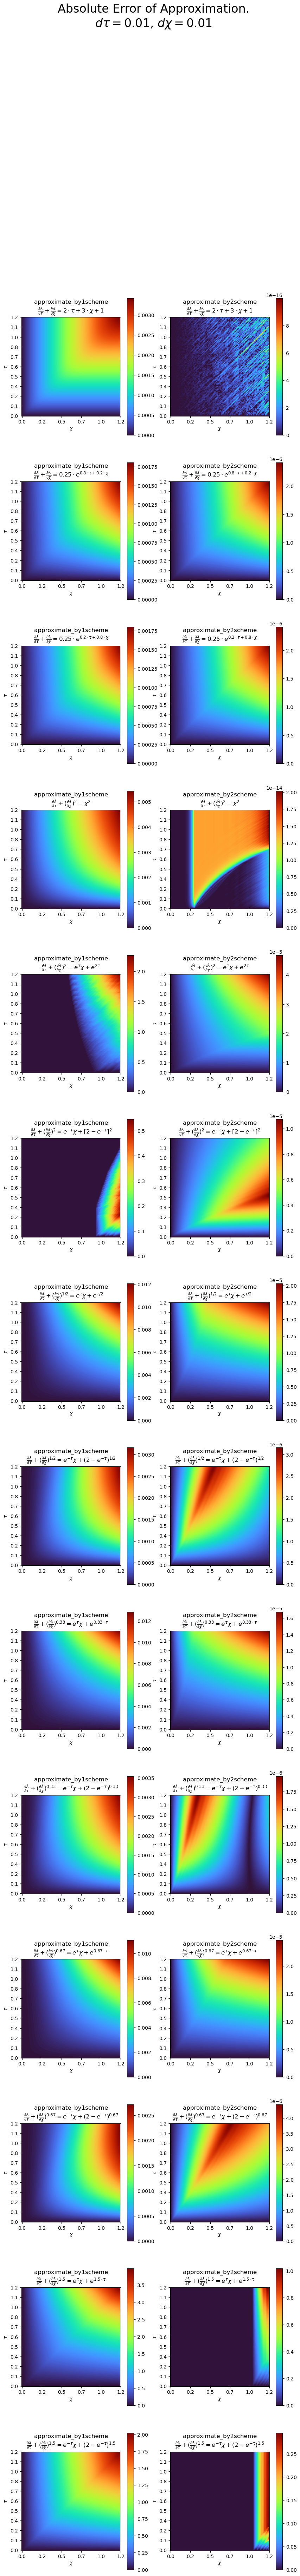

In [33]:
nrows = len(problems)
ncols = len(approximators)

fig, axs = plt.subplots(nrows, ncols)
fig.set_figheight(6*nrows)
fig.set_figwidth(5*ncols)

fig.suptitle(f'Absolute Error of Approximation.\n$d\\tau = {dtau}$, $d\\chi = {dchi}$', fontsize=24)

xticks = np.linspace(0, len(chis), 6)
yticks = np.linspace(0, len(taus), 11)

for i in range(len(approximations_smaller)):
    i_problem = approximations_smaller.loc[i, 'problem-id']
    i_scheme = approximations_smaller.loc[i, 'scheme-id']
    
    title =  approximators[i_scheme]['scheme'].__name__ + '\n' + problems[i_problem]['title']
    
    absolute_error = abs(solutions_smoller[i_problem] - approximations_smaller.loc[i, 'sol'])
    
    axs[i_problem, i_scheme].set_title(title)
    mappable = axs[i_problem, i_scheme].imshow(absolute_error, origin='lower', cmap='turbo')
    plt.colorbar(mappable)
    
    axs[i_problem, i_scheme].set_xticks(xticks, np.round(xticks*dchi, 1))
    axs[i_problem, i_scheme].set_xlabel(r'$\chi$')
    axs[i_problem, i_scheme].set_yticks(yticks, np.round(yticks*dtau, 1))
    axs[i_problem, i_scheme].set_ylabel(r'$\tau$')
    
filename = 'pics/Absolute Error on Smaller Grid.png'
fig.savefig(filename)

__Conclusion:__ 
The 2nd order approximaton is better than the 1st order approximation.

## Larger grid

In [34]:
# define parameters

dtau = 0.5
dchi = 0.5

ntau = 121
nchi = 121


taus = dtau*np.arange(ntau)
chis = dchi*np.arange(nchi)

tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

print(f'The grid on space τ×χ is defined by {ntau}×{nchi} points with step sizes dτ={dtau} and dχ={dchi}.')

The grid on space τ×χ is defined by 121×121 points with step sizes dτ=0.5 and dχ=0.5.


In [35]:
# find analytical solutions to the problems over grid

solutions_bigger = []

for problem in tqdm(problems, total=len(problems)):
    try:
        solution = problem['analytical'](tau_space, chi_space)
    except ValueError:
        solution = [[problem['analytical'](tau_space[j, k], chi_space[j, k]) 
                     for k in range(tau_space.shape[1])] 
                    for j in range(tau_space.shape[0])]
    solutions_bigger.append(np.array(solution))
    
np.array(solutions_bigger).shape

  0%|          | 0/14 [00:00<?, ?it/s]

(14, 121, 121)

In [38]:
# find approximations by schemes

approximations_bigger = []

with tqdm(total=len(problems)) as bar_problems:
    with tqdm(total=len(approximators)) as bar_schemes:
        with tqdm(total=ntau*nchi) as bar_inner:
            for i_problem in range(len(problems)):
                bar_schemes.reset()
                
                nu = problems[i_problem]['nu']
                n = problems[i_problem]['n']
                border = problems[i_problem]['border']
                initial = problems[i_problem]['initial']
                
                for i_scheme in range(len(approximators)):
                    bar_inner.reset()
                    scheme = approximators[i_scheme]['scheme']
                    
                    timer = time.perf_counter()
                    if approximators[i_scheme]['bar-total'] is None:
                        bar_inner.total = 1
                        bar_inner.refresh()
                        sol, tau, chi = scheme(nu=nu, initial=initial, border=border, n=n, 
                                               dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi)
                        bar_inner.update()
                    else:
                        bar_inner.total = approximators[i_scheme]['bar-total'](ntau, nchi)
                        bar_inner.refresh()
                        sol, tau, chi = scheme(nu=nu, initial=initial, border=border, n=n, 
                                               dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, 
                                               bar=bar_inner)
                    timer = time.perf_counter() - timer
                    approximations_bigger.append(
                        {
                            'problem-id': i_problem, 
                            'scheme-id': i_scheme, 
                            'scheme': approximators[i_scheme]['scheme'].__name__, 
                            'sol': np.array(sol), 
                            'tau': np.array(tau), 
                            'chi': np.array(chi), 
                            'time' : timer
                        }
                    )
                    
                    bar_schemes.update()
                bar_problems.update()
                
approximations_bigger = pd.DataFrame(approximations_bigger)

approximations_bigger.pivot(index='scheme', columns='problem-id', values='time')

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/14641 [00:00<?, ?it/s]

/usr/lib64/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/lib64/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/fedora/Jupyter/river-profiles/src/approximation.py:77: RuntimeWarning: invalid value encountered in power
  f = lambda sol: sol - sols[j+1, k] - dchi*(nu_val - (sol - sols[j, k+1])/dtau)**(1/n)
/home/fedora/Jupyter/river-profiles/src/approximation.py:161: RuntimeWarning: invalid value encountered in power
  f = lambda sol: 0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi - (nu_val - 0.5*(sol + sols[j+1, k] - sols[j, k+1] - sols[j, k])/dtau)**(1/n)
/home/fedora/Jupyter/river-profiles/src/approximation.py:162

problem-id                   0         1         2         3         4   \
scheme                                                                    
approximate_by1scheme  2.045860  1.944047  1.951474  2.347821  1.734895   
approximate_by2scheme  3.298722  2.959045  2.903680  2.726570  2.934251   

problem-id                   5         6         7          8         9   \
scheme                                                                     
approximate_by1scheme  1.752043  4.230154  1.707999   7.231243  2.335762   
approximate_by2scheme  3.557528  8.316014  2.821079  13.421159  3.384854   

problem-id                   10        11        12        13  
scheme                                                         
approximate_by1scheme  3.094693  1.756793  2.314002  2.246564  
approximate_by2scheme  5.792743  2.901179  3.929443  3.143001

In [39]:
approximations_bigger['lam'] = [problems[row['problem-id']]['analytical'](row['tau'], row['chi']) for index, row in approximations_bigger.iterrows()]
approximations_bigger = approximations_bigger.join(pd.DataFrame(problems), on='problem-id')

In [40]:
approximations_bigger['nu-str'] = ['$' + s[s.find('=') + 2:] for s in approximations_bigger['title']]

In [41]:
for score in scores:
    approximations_bigger[score.__name__] = [score(np.concatenate(approximations_bigger.loc[i, 'lam']), 
                                                   np.concatenate(approximations_bigger.loc[i, 'sol'])) for i in approximations_bigger.index]

In [42]:
approximations_bigger[np.concatenate([['n', 'nu-str', 'initial-str', 'scheme'], 
                                      [score.__name__ for score in scores]])].pivot(index=['n', 'nu-str', 'initial-str'], 
                                                                                     columns=['scheme'])

max_error  \
scheme                                                                                             approximate_by1scheme   
n    nu-str                                      initial-str                                                               
0.33 $e^\tau\chi + e^{0.33\cdot\tau}$            $\lambda(0, \chi) = \chi$                                  5.310334e+27   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{0.33}$    $\lambda(0, \chi) = \chi$                                  1.345619e+01   
0.50 $e^\tau\chi + e^{\tau/2}$                   $\lambda(0, \chi) = \chi$                                  4.396728e+27   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{1/2}$     $\lambda(0, \chi) = \chi$                                  1.329831e+01   
0.67 $e^\tau\chi + e^{0.67\cdot\tau}$            $\lambda(0, \chi) = \chi$                                  3.654424e+27   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{0.67}$    $\lambda(0, \chi) = \chi$                                  1.312637e+01   
1.00 $0.25\cdot e^{0.2\cdot\tau + 0.8\cdot\chi}$ $0.25\cdot(e^{0.8\cdot\chi} - e^{-0.2\cdot\chi})$          5.050717e+24   
     $0.25\cdot e^{0.8\cdot\tau + 0.2\cdot\chi}$ $0.25\cdot(e^{0.2\cdot\chi} - e^{-0.8\cdot\chi})$          5.050717e+24   
     $2\cdot\tau + 3\cdot\chi + 1$               $\lambda(0, \chi) = 0.5\cdot\chi^2 + 1\cdot\chi$           8.536954e+00   
1.50 $e^\tau\chi + e^{1.5\cdot\tau}$             $\lambda(0, \chi) = \chi$                                  6.852044e+27   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{1.5}$     $\lambda(0, \chi) = \chi$                                  1.195000e+02   
2.00 $\chi^2$                                    $\lambda(0, \chi) = \frac{\chi^2}{2}$                      1.500000e+01   
     $e^\tau\chi + e^{2\tau}$                    $\lambda(0, \chi) = \chi$                                  6.794944e+27   
     $e^{-\tau}\chi + [2 - e^{-\tau}]^2$         $\lambda(0, \chi) = \chi$                                  9.141540e+01   

                                                                                                                          \
scheme                                                                                             approximate_by2scheme   
n    nu-str                                      initial-str                                                               
0.33 $e^\tau\chi + e^{0.33\cdot\tau}$            $\lambda(0, \chi) = \chi$                                  5.212667e+27   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{0.33}$    $\lambda(0, \chi) = \chi$                                  5.999602e-01   
0.50 $e^\tau\chi + e^{\tau/2}$                   $\lambda(0, \chi) = \chi$                                  4.421529e+27   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{1/2}$     $\lambda(0, \chi) = \chi$                                  5.884184e-01   
0.67 $e^\tau\chi + e^{0.67\cdot\tau}$            $\lambda(0, \chi) = \chi$                                  3.630390e+27   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{0.67}$    $\lambda(0, \chi) = \chi$                                  5.756648e-01   
1.00 $0.25\cdot e^{0.2\cdot\tau + 0.8\cdot\chi}$ $0.25\cdot(e^{0.8\cdot\chi} - e^{-0.2\cdot\chi})$          2.952434e+23   
     $0.25\cdot e^{0.8\cdot\tau + 0.2\cdot\chi}$ $0.25\cdot(e^{0.2\cdot\chi} - e^{-0.8\cdot\chi})$          2.952434e+23   
     $2\cdot\tau + 3\cdot\chi + 1$               $\lambda(0, \chi) = 0.5\cdot\chi^2 + 1\cdot\chi$           3.410605e-12   
1.50 $e^\tau\chi + e^{1.5\cdot\tau}$             $\lambda(0, \chi) = \chi$                                  6.787314e+27   
     $e^{-\tau}\chi + (2 - e^{-\tau})^{1.5}$     $\lambda(0, \chi) = \chi$                                  1.245608e+02   
2.00 $\chi^2$                                    $\lambda(0, \chi) = \frac{\chi^2}{2}$                      1.136868e-12   
     $e^\tau\chi + e^{2\tau}$                    $\lambda(0, \chi) = \chi$                                  6.890379e+27   
     $e^{-\tau}\ch

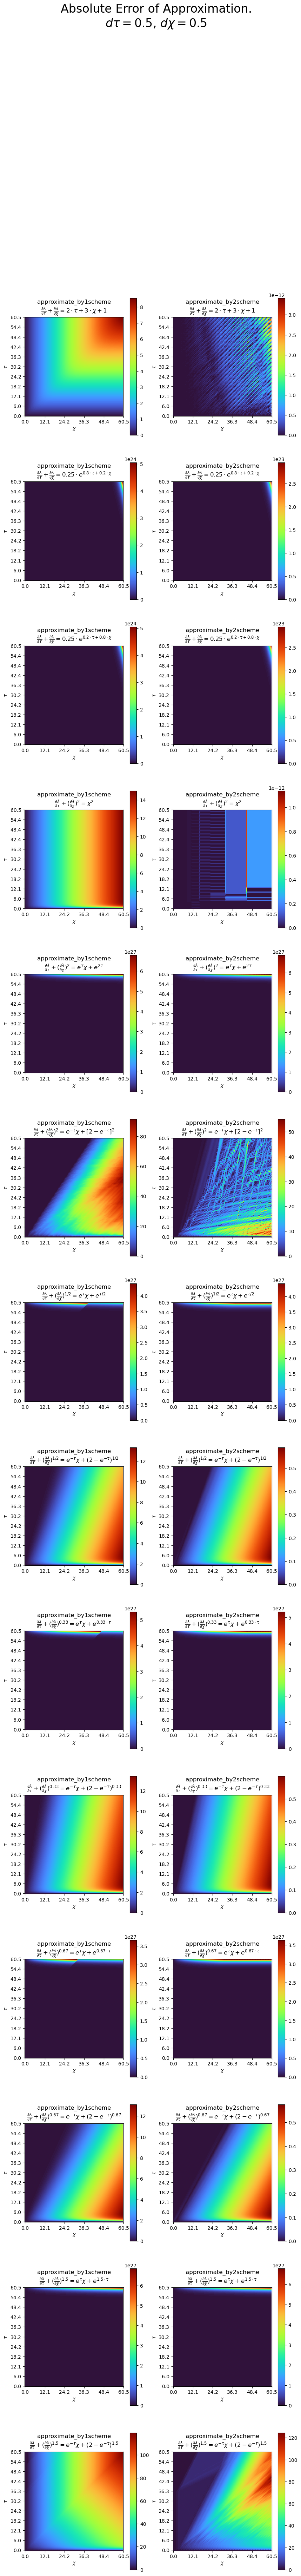

In [43]:
nrows = len(problems)
ncols = len(approximators)

fig, axs = plt.subplots(nrows, ncols)
fig.set_figheight(6*nrows)
fig.set_figwidth(5*ncols)

fig.suptitle(f'Absolute Error of Approximation.\n$d\\tau = {dtau}$, $d\\chi = {dchi}$', fontsize=24)

xticks = np.linspace(0, len(chis), 6)
yticks = np.linspace(0, len(taus), 11)

for i in range(len(approximations_bigger)):
    i_problem = approximations_bigger.loc[i, 'problem-id']
    i_scheme = approximations_bigger.loc[i, 'scheme-id']
    
    title =  approximators[i_scheme]['scheme'].__name__ + '\n' + problems[i_problem]['title']
    
    absolute_error = abs(solutions_bigger[i_problem] - approximations_bigger.loc[i, 'sol'])
    
    axs[i_problem, i_scheme].set_title(title)
    mappable = axs[i_problem, i_scheme].imshow(absolute_error, origin='lower', cmap='turbo')
    plt.colorbar(mappable)
    
    axs[i_problem, i_scheme].set_xticks(xticks, np.round(xticks*dchi, 1))
    axs[i_problem, i_scheme].set_xlabel(r'$\chi$')
    axs[i_problem, i_scheme].set_yticks(yticks, np.round(yticks*dtau, 1))
    axs[i_problem, i_scheme].set_ylabel(r'$\tau$')
    
filename = 'pics/Absolute Error on Bigger Grid.png'
fig.savefig(filename)

__Conclusion:__ 
When `dtau` and `dchi` increase, the 2nd order approximation became less accurate, than the 1st sometime.